@author: Alexandre Pereira Santos <br>
alexandre.santos(at)lmu.de

## Description
- this is where code goes to die
- this code should not necessarily work and may include only parts of larger scripts

# cost-distance function
I am testing alternatives below.

In [ ]:
from skimage.graph import route_through_array

def get_weight_distance_raster_2(roads_full_raster, gdf_origin_points, slope_raster_path, ref_raster_path, wt_roads=1, wt_no_roads=100, wt_slope=1):
    """Calculate accumulated cost raster using origin points and road density.
    
    Args:
        roads_full_raster: Pre-calculated raster of road network
        gdf_origin_points: GeoDataFrame containing origin points
        slope_raster_path: Path to slope raster file
        ref_raster_path: Path to reference raster for alignment
        wt_roads: Weight for road cells (default=1)
        wt_no_roads: Weight for non-road cells (default=100)
        wt_slope: Weight multiplier for slope influence (default=1)
    
    Returns:
        Accumulated cost raster
    """
    
    # Read slope raster
    with rasterio.open(slope_raster_path) as src:
        slope_raster = src.read(1)
        
    # Normalize slope to 0-1 range
    slope_normalized = (slope_raster - np.min(slope_raster)) / (np.max(slope_raster) - np.min(slope_raster))
    
    # Create and immediately close temporary files to get their paths
    with tempfile.NamedTemporaryFile(suffix='.tif', delete=False) as source_file:
        source_path = source_file.name
    with tempfile.NamedTemporaryFile(suffix='.tif', delete=False) as cost_file:
        cost_path = cost_file.name
    with tempfile.NamedTemporaryFile(suffix='.tif', delete=False) as output_file:
        output_path = output_file.name
    
    try:
        # Save source (origin points) and cost rasters to temporary files
        with rasterio.open(ref_raster_path) as ref:
            profile = ref.profile.copy()
            
            # Rasterize origin points
            origin_points_raster = features.rasterize(
                [(geom, 1) for geom in gdf_origin_points.geometry],
                out_shape=ref.shape,
                transform=ref.transform,
                fill=0,
                dtype=rasterio.float32
            )
        
        with rasterio.open(source_path, 'w', **profile) as dst:
            dst.write(origin_points_raster.astype(rasterio.float32), 1)
        
        # Create combined cost surface incorporating roads and slope
        # Base cost from roads
        cost_surface = np.where(roads_full_raster == 1, wt_roads, wt_no_roads)
        # Add slope influence
        cost_surface = cost_surface * (1 + slope_normalized * wt_slope)
        
        with rasterio.open(cost_path, 'w', **profile) as dst:
            dst.write(cost_surface.astype(rasterio.float32), 1)
        
        # Run GDAL cost distance algorithm
        src_ds = gdal.Open(source_path)
        src_band = src_ds.GetRasterBand(1)
        
        out_ds = gdal.GetDriverByName('GTiff').Create(output_path, 
                                                     src_ds.RasterXSize, 
                                                     src_ds.RasterYSize, 
                                                     1, 
                                                     gdal.GDT_Float32)
        out_band = out_ds.GetRasterBand(1)
        
        # Find the least-cost path using Dijkstra's algorithm
        
        # Convert origin points to indices
        origin_indices = np.column_stack(np.where(origin_points_raster == 1))
        
        # Initialize an empty array to store the accumulated cost
        accumulated_cost_raster = np.full(cost_surface.shape, np.inf)
        
        for origin in origin_indices:
            indices, weight = route_through_array(cost_surface, origin, end=None, fully_connected=True, geometric=True)
            for ind, w in zip(indices, weight):
                accumulated_cost_raster[tuple(ind)] = min(accumulated_cost_raster[tuple(ind)], w)
        
        # Set no-data values
        accumulated_cost_raster[accumulated_cost_raster == np.inf] = -9999
        
        # Clean up GDAL datasets
        src_ds = None
        out_ds = None
        
        # Read result back
        with rasterio.open(output_path) as src:
            accumulated_cost_raster = src.read(1)
        
        # calculate a normalised version of the accumulated cost raster
        accumulated_cost_raster_normalized = (accumulated_cost_raster - np.nanmin(accumulated_cost_raster))/(np.nanmax(accumulated_cost_raster) - np.nanmin(accumulated_cost_raster))
        return accumulated_cost_raster, accumulated_cost_raster_normalized
         
        
    finally:
        # Clean up temporary files
        for temp_file in [source_path, cost_path, output_path]:
            try:
                os.unlink(temp_file)
            except Exception as e:
                print(f"Warning: Could not delete temporary file {temp_file}: {e}")

In [ ]:
def get_weight_distance_raster_3(roads_full_raster, gdf_origin_points, slope_raster_path, ref_raster_path=ref_raster_path, 
                             wt_roads=1, wt_no_roads=100, wt_slope=1):
    """Calculate weighted distance raster using GDAL's cost distance function.
    
    Args:
        roads_full_raster: Pre-calculated raster of road network
        gdf_origin_points: GeoDataFrame containing origin points
        slope_raster_path: Path to slope raster file
        ref_raster_path: Path to reference raster for alignment
        wt_roads: Weight for road cells (default=1)
        wt_no_roads: Weight for non-road cells (default=100)
        wt_slope: Weight multiplier for slope influence (default=1)
    
    Returns:
        Tuple containing (distance_raster, normalized_distance_raster)
    """

    
    # Read slope raster
    with rasterio.open(slope_raster_path) as src:
        slope_raster = src.read(1)
        
    # Normalize slope to 0-1 range
    slope_normalized = (slope_raster - np.min(slope_raster)) / (np.max(slope_raster) - np.min(slope_raster))
    
    # Create and immediately close temporary files to get their paths
    with tempfile.NamedTemporaryFile(suffix='.tif', delete=False) as source_file:
        source_path = source_file.name
    with tempfile.NamedTemporaryFile(suffix='.tif', delete=False) as cost_file:
        cost_path = cost_file.name
    with tempfile.NamedTemporaryFile(suffix='.tif', delete=False) as output_file:
        output_path = output_file.name
    
    try:
        # Save source (origin points) and cost rasters to temporary files
        with rasterio.open(ref_raster_path) as ref:
            profile = ref.profile.copy()
            
            # Rasterize origin points
            origin_points_raster = features.rasterize(
                [(geom, 1) for geom in gdf_origin_points.geometry],
                out_shape=ref.shape,
                transform=ref.transform,
                fill=0,
                dtype=rasterio.float32
            )
        
        with rasterio.open(source_path, 'w', **profile) as dst:
            dst.write(origin_points_raster.astype(rasterio.float32), 1)
        
        # Create combined cost surface incorporating roads and slope
        # Base cost from roads
        cost_surface = np.where(roads_full_raster == 1, wt_roads, wt_no_roads)
        # Add slope influence
        cost_surface = cost_surface * (1 + slope_normalized * wt_slope)
        
        with rasterio.open(cost_path, 'w', **profile) as dst:
            dst.write(cost_surface.astype(rasterio.float32), 1)
        
        # Run GDAL cost distance algorithm
        src_ds = gdal.Open(source_path)
        src_band = src_ds.GetRasterBand(1)
        
        out_ds = gdal.GetDriverByName('GTiff').Create(output_path, 
                                                     src_ds.RasterXSize, 
                                                     src_ds.RasterYSize, 
                                                     1, 
                                                     gdal.GDT_Float32)
        out_band = out_ds.GetRasterBand(1)
        
        gdal.ComputeProximity(src_band, out_band, 
                            ['DISTUNITS=GEO',
                             'MAX_DISTANCE=100000',
                             'NODATA=-9999'],
                            callback=gdal.TermProgress_nocb)
        
        # Clean up GDAL datasets
        src_ds = None
        out_ds = None
        
        # Read result back
        with rasterio.open(output_path) as src:
            distance_raster = src.read(1)
        
        # Apply Gaussian smoothing to create gradual transitions
        distance_raster = gaussian_filter(distance_raster, sigma=1)
        
        # Normalize the distance raster
        valid_mask = distance_raster != -9999
        min_val = np.min(distance_raster[valid_mask])
        max_val = np.max(distance_raster[valid_mask])
        distance_raster_normalized = np.where(valid_mask,
                                            (distance_raster - min_val) / (max_val - min_val),
                                            -9999)
        
        return distance_raster, distance_raster_normalized
        
    finally:
        # Clean up temporary files
        for temp_file in [source_path, cost_path, output_path]:
            try:
                os.unlink(temp_file)
            except Exception as e:
                print(f"Warning: Could not delete temporary file {temp_file}: {e}")

In [ ]:
import os
import numpy as np
import rasterio
from rasterio import features
from osgeo import gdal
from skimage.graph import route_through_array

def get_weight_distance_raster_5(path_raster, 
                                 gdf_origin_points, 
                                 slope_raster_path, 
                                 ref_raster_path, 
                                 wt_roads=1, 
                                 wt_no_roads=100, 
                                 wt_slope=1):
    """Calculate accumulated cost raster using origin points and road density.
    
    Args:
        roads_full_raster: Pre-calculated raster of road network
        gdf_origin_points: GeoDataFrame containing origin points
        slope_raster_path: Path to slope raster file
        ref_raster_path: Path to reference raster for alignment
        wt_roads: Weight for road cells (default=1)
        wt_no_roads: Weight for non-road cells (default=100)
        wt_slope: Weight multiplier for slope influence (default=1)
    
    Returns:
        Accumulated cost raster and normalized accumulated cost raster
    """
    
    try:
        # Read slope raster
        with rasterio.open(slope_raster_path) as src:
            slope_raster = src.read(1)
            print('slope:',slope_raster.shape)
        # Normalize slope to 0-1 range
        slope_normalized = (slope_raster - np.min(slope_raster)) / (np.max(slope_raster) - np.min(slope_raster))
        print('slope normal:',slope_normalized.shape)
        # Create and immediately close temporary files to get their paths
               
        # Save source (origin points) and cost rasters to temporary files
        with rasterio.open(ref_raster_path) as ref:
            profile = ref.profile.copy()
            
            # Rasterize origin points
            origin_points_raster = features.rasterize(
                [(geom, 1) for geom in gdf_origin_points.geometry],
                out_shape=ref.shape,
                transform=ref.transform,
                fill=0,
                dtype=rasterio.float32
            )
            print('origin:',origin_points_raster.shape)
        
        # Create combined cost surface incorporating roads and slope
        # Base cost from roads
        cost_surface = np.where(path_raster == 1, wt_roads, wt_no_roads)
        # Add slope influence
        cost_surface = cost_surface * (1 + slope_normalized * wt_slope)
        print('cost:',cost_surface.shape)
        
        # Find the least-cost path using Dijkstra's algorithm
        
        # Convert origin points to indices
        origin_indices = np.stack(np.where(origin_points_raster == 1), axis=1)
        if origin_indices.size == 0:
            raise ValueError("No origin points found in the rasterized origin points.")
        print('or length', len(origin_indices),
              ', or indices:',origin_indices[-1],
              ',or type',type(origin_indices[-1]))
        # print(type(origin_indices))

        # Calculate the destination as the point with the highest density in the path_raster
        densest_point_index = np.argmax(path_raster)
        destination = np.unravel_index(densest_point_index, path_raster.shape)
        print('densest_point:', destination)
               
        # Initialize an empty array to store the accumulated cost
        accumulated_cost_raster = np.full(cost_surface.shape, np.inf)
        print('empty cost raster:',accumulated_cost_raster.shape)

        for origin in origin_indices[1:10]:
            print('origin:',origin, '\ndestination:',destination)
            # Find the indices of the cells with the minimum cost path
            indices, weight = route_through_array(cost_surface, 
                                                  tuple(origin), 
                                                  end=destination, 
                                                  fully_connected=True, 
                                                  geometric=True)
            print('indices:',indices, '\nweight:',weight)
            if indices is None or weight is None:
                print("Error: indices or weight is None")
                continue

            for ind, w in zip(indices, weight):
                try:
                    accumulated_cost_raster[tuple(ind)] = min(accumulated_cost_raster[tuple(ind)], w)
                except IndexError as e:
                    print(f"IndexError: {e} for index {ind}")
        
        # Set no-data values
        accumulated_cost_raster[accumulated_cost_raster == np.inf] = -9999
        
        # Calculate a normalized version of the accumulated cost raster
        accumulated_cost_raster_normalized = (accumulated_cost_raster - np.nanmin(accumulated_cost_raster)) / (np.nanmax(accumulated_cost_raster) - np.nanmin(accumulated_cost_raster))
        
        return accumulated_cost_raster, accumulated_cost_raster_normalized
        
    except Exception as e:
        print(f"Error in function: {e}")
        return None, None

In [ ]:
import os
import numpy as np
import rasterio
from rasterio import features
from osgeo import gdal
from skimage.graph import route_through_array

def get_weight_distance_raster_6(path_raster, 
                                 gdf_origin_points, 
                                 slope_raster_path, 
                                 ref_raster_path, 
                                 wt_roads=1, 
                                 wt_no_roads=100, 
                                 wt_slope=1):
    """Calculate accumulated cost raster using origin points and road density.
    
    Args:
        roads_full_raster: Pre-calculated raster of road network
        gdf_origin_points: GeoDataFrame containing origin points
        slope_raster_path: Path to slope raster file
        ref_raster_path: Path to reference raster for alignment
        wt_roads: Weight for road cells (default=1)
        wt_no_roads: Weight for non-road cells (default=100)
        wt_slope: Weight multiplier for slope influence (default=1)
    
    Returns:
        Accumulated cost raster and normalized accumulated cost raster
    """
    
    try:
        # Read slope raster
        with rasterio.open(slope_raster_path) as src:
            slope_raster = src.read(1)
            print('slope:',slope_raster.shape)
        # Normalize slope to 0-1 range
        slope_normalized = (slope_raster - np.min(slope_raster)) / (np.max(slope_raster) - np.min(slope_raster))
        print('slope normal:',slope_normalized.shape)
        print('path',path_raster.shape)
        # Create and immediately close temporary files to get their paths
               
        # Save source (origin points) and cost rasters to temporary files
        with rasterio.open(ref_raster_path) as ref:
            profile = ref.profile.copy()
            
            # Rasterize origin points
            origin_points_raster = features.rasterize(
                [(geom, 1) for geom in gdf_origin_points.geometry],
                out_shape=ref.shape,
                transform=ref.transform,
                fill=0,
                dtype=rasterio.float32
            )
            print('origin:',origin_points_raster.shape)
        
        # Create combined cost surface incorporating roads and slope
        # Base cost from roads
        cost_surface = np.where(path_raster == 1, wt_roads, wt_no_roads)
        # Add slope influence
        cost_surface = cost_surface * (1 + slope_normalized * wt_slope)
        print('cost:',cost_surface.shape)
        
        # Find the least-cost path using Dijkstra's algorithm
        
        # Convert origin points to indices
        origin_indices = [tuple(ind) for ind in np.stack(np.where(origin_points_raster == 1), axis=1)]
        if len(origin_indices) == 0:
            raise ValueError("No origin points found in the rasterized origin points.")
        print('origin length', len(origin_indices),
              ', \norigin first index:',origin_indices[0],
              ', \norigin last index:',origin_indices[-1],
              ', \norigin type',type(origin_indices[-1]))
        # print(type(origin_indices))

        # Check if all origin points are within the bounds of the cost_surface
        for origin in origin_indices:
            if not (0 <= origin[0] < cost_surface.shape[0] and 0 <= origin[1] < cost_surface.shape[1]):
                raise ValueError(f"Origin point {origin} is out of bounds for the cost_surface with shape {cost_surface.shape}")

        # Calculate the destination as the point with the highest density in the path_raster
        densest_point_index = np.argmax(path_raster)
        destination = np.unravel_index(densest_point_index, path_raster.shape)
        print('densest_point:', destination)
               
        # Initialize an empty array to store the accumulated cost
        accumulated_cost_raster = np.full(cost_surface.shape, np.inf)
        print('empty cost raster:',accumulated_cost_raster.shape)

        
        # Find the indices of the cells with the minimum cost path
        indices, weight = route_through_array(cost_surface, 
                                                origin_indices, 
                                                end=destination, 
                                                fully_connected=True, 
                                                geometric=True)
        print('indices:',indices, '\nweight:',weight)
        if indices is None or weight is None:
            print("Error: indices or weight is None")
      
        # Set no-data values
        accumulated_cost_raster[accumulated_cost_raster == np.inf] = -9999
        
        # Calculate a normalized version of the accumulated cost raster
        accumulated_cost_raster_normalized = (accumulated_cost_raster - np.nanmin(accumulated_cost_raster)) / (np.nanmax(accumulated_cost_raster) - np.nanmin(accumulated_cost_raster))
        
        return accumulated_cost_raster, accumulated_cost_raster_normalized
        
    except Exception as e:
        print(f"Error in function: {e}")
        return None, None

In [ ]:
from skimage.graph import MCP
path_raster=roads_full_raster
gdf_origin_points = health[health.major == 1]
raster_file = case_city + '_DEM_slope_deg_TanDEM_X_30m.tif'
slope_raster_path = processed_path / raster_file
ref_raster_path=ref_raster_path 
wt_roads=1 
wt_no_roads=100
wt_slope=1
"""Calculate accumulated cost raster using origin points and road density.

Args:
    roads_full_raster: Pre-calculated raster of road network
    gdf_origin_points: GeoDataFrame containing origin points
    slope_raster_path: Path to slope raster file
    ref_raster_path: Path to reference raster for alignment
    wt_roads: Weight for road cells (default=1)
    wt_no_roads: Weight for non-road cells (default=100)
    wt_slope: Weight multiplier for slope influence (default=1)

Returns:
    Accumulated cost raster and normalized accumulated cost raster
"""

# Read slope raster
with rasterio.open(slope_raster_path) as src:
    slope_raster = src.read(1)
    print('slope:',slope_raster.shape)
# Normalize slope to 0-1 range
slope_normalized = (slope_raster - np.min(slope_raster)) / (np.max(slope_raster) - np.min(slope_raster))
print('slope normal:',slope_normalized.shape)
print('path',path_raster.shape)
# Create and immediately close temporary files to get their paths
        
# Save source (origin points) and cost rasters to temporary files
with rasterio.open(ref_raster_path) as ref:
    profile = ref.profile.copy()
    
    # Rasterize origin points
    origin_points_raster = features.rasterize(
        [(geom, 1) for geom in gdf_origin_points.geometry],
        out_shape=ref.shape,
        transform=ref.transform,
        fill=0,
        dtype=rasterio.float32
    )
    print('origin:',origin_points_raster.shape)

# Create combined cost surface incorporating roads and slope
# Base cost from roads
cost_surface = np.where(path_raster == 1, wt_roads, wt_no_roads)
# Add slope influence
cost_surface = cost_surface * (1 + slope_normalized * wt_slope)
print('cost:',cost_surface.shape)

# Find the least-cost path using Dijkstra's algorithm

# Convert origin points to indices
origin_indices = [tuple(ind) for ind in np.stack(np.where(origin_points_raster == 1), axis=1)]
if len(origin_indices) == 0:
    raise ValueError("No origin points found in the rasterized origin points.")
print('origin length', len(origin_indices),
        ', \norigin first index:',origin_indices[0],
        ', \norigin last index:',origin_indices[-1],
        ', \norigin type',type(origin_indices[-1]))
# print(type(origin_indices))

# Calculate the destination as the point with the highest density in the path_raster
densest_point_index = np.argmax(path_raster)
destination = np.unravel_index(densest_point_index, path_raster.shape)
print('densest_point:', destination)
        
# Initialize an empty array to store the accumulated cost
accumulated_cost_raster = np.full(cost_surface.shape, np.inf)
print('empty cost raster:',accumulated_cost_raster.shape)
#m = MCP(cost_surface)
#cost_array, tracebacks_array = m.find_costs(origin_indices, destination)

img = np.random.rand(400,400)
img = img.astype(dtype=int)
starts = [[1,1], [2,2], [3,3], [4,5], [6,17]]
ends = [[301,201], [300,300], [305,305], [304,328], [336,317]]

m = MCP(img)
cost_array, tracebacks_array = m.find_costs(starts, ends)

In [ ]:
def get_weight_distance_raster_7(path_raster, gdf_origin_points, 
                                 raster_file, slope_raster_path, 
                                 ref_raster_path=ref_raster_path, 
                                 wt_roads=1, wt_no_roads=100, 
                                 wt_slope=1):
    """Calculate accumulated cost raster using origin points and road density.

    Args:
        roads_full_raster: Pre-calculated raster of road network
        gdf_origin_points: GeoDataFrame containing origin points
        slope_raster_path: Path to slope raster file
        ref_raster_path: Path to reference raster for alignment
        wt_roads: Weight for road cells (default=1)
        wt_no_roads: Weight for non-road cells (default=100)
        wt_slope: Weight multiplier for slope influence (default=1)

    Returns:
        Accumulated cost raster and normalized accumulated cost raster
    """

    # Read slope raster
    with rasterio.open(slope_raster_path) as src:
        slope_raster = src.read(1)
        print('slope:',slope_raster.shape)
    # Normalize slope to 0-1 range
    slope_normalized = (slope_raster - np.min(slope_raster)) / (np.max(slope_raster) - np.min(slope_raster))
    print('slope normal:',slope_normalized.shape)
    print('path',path_raster.shape)
    # Create and immediately close temporary files to get their paths
            
    # Save source (origin points) and cost rasters to temporary files
    with rasterio.open(ref_raster_path) as ref:
        profile = ref.profile.copy()
        
        # Rasterize origin points
        origin_points_raster = features.rasterize(
            [(geom, 1) for geom in gdf_origin_points.geometry],
            out_shape=ref.shape,
            transform=ref.transform,
            fill=0,
            dtype=rasterio.float32
        )
        print('origin:',origin_points_raster.shape)

    # Create combined cost surface incorporating roads and slope
    # Base cost from roads
    cost_surface = np.where(path_raster == 1, wt_roads, wt_no_roads)
    # Add slope influence
    cost_surface = cost_surface * (1 + slope_normalized * wt_slope)
    print('cost:',cost_surface.shape)

    # Find the least-cost path using Dijkstra's algorithm

    # Convert origin points to indices
    origin_indices = [tuple(ind) for ind in np.stack(np.where(origin_points_raster == 1), axis=1)]
    if len(origin_indices) == 0:
        raise ValueError("No origin points found in the rasterized origin points.")
    print('origin length', len(origin_indices),
            ', \norigin first index:',origin_indices[0],
            ', \norigin last index:',origin_indices[-1],
            ', \norigin type',type(origin_indices[-1]))
    # print(type(origin_indices))

    # Calculate the destination as the point with the highest density in the path_raster
    densest_point_index = np.argmax(path_raster)
    destination = np.unravel_index(densest_point_index, path_raster.shape)
    print('densest_point:', destination)

    # Initialize an empty array to store the accumulated cost
    accumulated_cost_raster = np.zeros_like(cost_surface)
    print('empty cost raster:',accumulated_cost_raster.shape)

    # iterate over the origin points
    # for i in range(len(origin_indices)):
    #     origin = origin_indices[i]
    #     print('origin:',origin, i,'/',len(origin_indices))
    #     # Find the indices of the cells with the minimum cost path
    for origin in origin_indices: #[1:10]
        print('origin:',origin, '\ndestination:',destination)
        # Find the indices of the cells with the minimum cost path
        indices, weight = route_through_array(cost_surface, 
                                                tuple(origin), 
                                                end=destination, 
                                                fully_connected=True, 
                                                geometric=True)
        print('indices:',len(indices), '\nweight:',weight)
        # add the minimum cost paths to the accumulated cost raster
        #indices = np.stack(indices, axis=-1)
        path = np.zeros_like(cost_surface)
        # propagate the values of the path to all cells in it
        v = weight / len(indices)
        for i in indices:
            #print('i:',i, type(i), 'v:',v)
            path[i] = v
        #path[indices[0], indices[1]] = weight
        print('path:',path.max())
        
        # add the path to the accumulated cost raster
        accumulated_cost_raster += path

    # Set no-data values
    accumulated_cost_raster = np.where(accumulated_cost_raster == np.inf, -9999, accumulated_cost_raster)

    # Calculate a normalized version of the accumulated cost raster
    accumulated_cost_raster_normalized = (accumulated_cost_raster - np.nanmin(accumulated_cost_raster)) / (np.nanmax(accumulated_cost_raster) - np.nanmin(accumulated_cost_raster))

    return accumulated_cost_raster, accumulated_cost_raster_normalized

In [ ]:
def get_weight_distance_raster_8(path_raster, gdf_origin_points, 
                                 slope_raster_path, 
                                 ref_raster_path=ref_raster_path, 
                                 wt_roads=1, wt_no_roads=100, 
                                 wt_slope=1):
    """Calculate accumulated cost raster using origin points and road density.

    Args:
        roads_full_raster: Pre-calculated raster of road network
        gdf_origin_points: GeoDataFrame containing origin points
        slope_raster_path: Path to slope raster file
        ref_raster_path: Path to reference raster for alignment
        wt_roads: Weight for road cells (default=1)
        wt_no_roads: Weight for non-road cells (default=100)
        wt_slope: Weight multiplier for slope influence (default=1)

    Returns:
        Accumulated cost raster and normalized accumulated cost raster
    """

    # Read slope raster
    with rasterio.open(slope_raster_path) as src:
        slope_raster = src.read(1)
        #print('slope:',slope_raster.shape)
    # Normalize slope to 0-1 range
    slope_normalized = (slope_raster - np.min(slope_raster)) / (np.max(slope_raster) - np.min(slope_raster))
    #print('slope normal:',slope_normalized.shape)
    print('path',path_raster.shape)
    # Create and immediately close temporary files to get their paths
            
    # Save source (origin points) and cost rasters to temporary files
    with rasterio.open(ref_raster_path) as ref:
        profile = ref.profile.copy()
        
        # Rasterize origin points
        origin_points_raster = features.rasterize(
            [(geom, 1) for geom in gdf_origin_points.geometry],
            out_shape=ref.shape,
            transform=ref.transform,
            fill=0,
            dtype=rasterio.float32
        )
        print('origin:',origin_points_raster.shape)

    # Create combined cost surface incorporating roads and slope
    # Base cost from roads
    cost_surface = np.where(path_raster == 1, wt_roads, wt_no_roads)
    # Add slope influence
    cost_surface = cost_surface * (1 + slope_normalized * wt_slope)
    print('cost:',cost_surface.shape)

    # Find the least-cost path using Dijkstra's algorithm

    # Convert origin points to indices
    origin_indices = [tuple(ind) for ind in np.stack(np.where(origin_points_raster == 1), axis=1)]
    if len(origin_indices) == 0:
        raise ValueError("No origin points found in the rasterized origin points.")
    #print('origin length', len(origin_indices),
    #        ', \norigin first index:',origin_indices[0],
    #        ', \norigin last index:',origin_indices[-1],
    #        ', \norigin type',type(origin_indices[-1]))
    # print(type(origin_indices))

    # Calculate the destination as the point with the highest density in the path_raster
    densest_point_index = np.argmax(path_raster)
    destination = np.unravel_index(densest_point_index, path_raster.shape)
    print('densest_point:', destination)

    # Initialize an empty array to store the accumulated cost
    accumulated_cost_raster = np.zeros_like(cost_surface)
    #print('empty cost raster:',accumulated_cost_raster.shape)

    # iterate over the origin points
    for i in range(len(origin_indices)):
        origin = origin_indices[i]
        print('origin:',origin, i,'/',len(origin_indices))
        # Find the indices of the cells with the minimum cost path
        #for origin in origin_indices: #[1:10]
        print('origin:',origin, '\ndestination:',destination)
        # Find the indices of the cells with the minimum cost path
        indices, weight = route_through_array(cost_surface, 
                                                tuple(origin), 
                                                end=destination, 
                                                fully_connected=True, 
                                                geometric=True)
        #print('indices:',len(indices), '\nweight:',weight)
        # add the minimum cost paths to the accumulated cost raster
        #indices = np.stack(indices, axis=-1)
        path = np.zeros_like(cost_surface)
        # propagate the values of the path to all cells in it
        v = weight / len(indices)
        for i in indices:
            #print('i:',i, type(i), 'v:',v)
            path[i] = v
        #path[indices[0], indices[1]] = weight
        #print('path:',path.max())
        
        # add the path to the accumulated cost raster
        accumulated_cost_raster += path

    # Set no-data values
    accumulated_cost_raster = np.where(accumulated_cost_raster == np.inf, -9999, accumulated_cost_raster)

    # Calculate a normalized version of the accumulated cost raster
    accumulated_cost_raster_normalized = (accumulated_cost_raster - np.nanmin(accumulated_cost_raster)) / (np.nanmax(accumulated_cost_raster) - np.nanmin(accumulated_cost_raster))

    return accumulated_cost_raster, accumulated_cost_raster_normalized

# density calc & function

In [ ]:
# load population raster files 1
with rasterio.open(external_path / img_name_2000,'r') as pop_raster_2000:
    # clip the raster to the AOI
    pop_2000_array, pop_2000_transform = mask(pop_raster_2000, getFeatures(AOI_gdf), crop=True)
    
    # calculate the area of the pixels in the rasters using the afine information
    pop_raster_2000_height = pop_2000_array.shape[1]
    pop_raster_2000_width = pop_2000_array.shape[2]
    pop_raster_2000_area = round(pop_2000_transform[0]*(-pop_2000_transform[4]),2)
    #print('size x', pop_2000_clipped_transform[0], '\nsize y', (-pop_2000_clipped_transform[4]), '\narea', round(pop_2000_clipped_transform[0]*(-pop_2000_clipped_transform[4]),2),
    #      '\nwidth',pop_2000_clipped.shape[2],'\nheight',pop_2000_clipped.shape[1])
    # pop_raster_2000_height, pop_raster_2000_width, pop_raster_2000_area = get_transform(pop_raster_2000)

    # calculate the population density
    density_2000 = pop_2000_array / pop_raster_2000_area
    # normalize the density
    density_2000_normal = np.round((density_2000 - np.nanmin(density_2000))/(np.nanmax(density_2000) - np.nanmin(density_2000)),4)
    density_2000_fill = np.where(np.isnan(density_2000_normal), 0, density_2000_normal)

with rasterio.open(external_path / img_name_2020,'r') as pop_raster_2020:
      # clip the raster to the AOI
      pop_2020_array, pop_2020_transform = mask(pop_raster_2020, getFeatures(AOI_gdf), crop=True)

      # calculate the area of the pixels in the rasters using the afine information
      pop_raster_2020_height = pop_2020_array.shape[1]
      pop_raster_2020_width = pop_2020_array.shape[2]
      pop_raster_2020_area = round(pop_2020_transform[0]*(-pop_2020_transform[4]),2)

      # calculate the population density
      density_2020 = pop_2020_array / pop_raster_2020_area
      # normalize the density
      density_2020_normal = np.round((density_2020 - np.nanmin(density_2020))/(np.nanmax(density_2020) - np.nanmin(density_2020)),4)
      density_2020_fill = np.where(np.isnan(density_2020_normal), 0, density_2020_normal)

In [ ]:
def calculate_density(image_path, aoi_gdf):
    """
    Load population raster, clip to AOI, and calculate normalized density
    
    Parameters:
    -----------
    image_path : pathlib.Path
        Path to the population raster file
        It should be a valid raster in a **projected** CRS
    aoi_gdf : GeoDataFrame
        Area of interest as a GeoDataFrame
    
    Returns:
    --------
    tuple
        (density_fill, pop_raster_area, pop_raster_height, pop_raster_width, pop_transform)
    """

    with rasterio.open(image_path, 'r') as pop_raster:
        # APS: It is is not necessary to check if the CRS are the same, as the getFeatures function does it for us        
        print(pop_raster.crs)
        # clip the raster to the AOI
        pop_array, pop_transform = mask(pop_raster, getFeatures(aoi_gdf), crop=True)
        
        # calculate the area of the pixels in the rasters using the affine information
        # pop_raster_height = pop_array.shape[1] # we get these properties straight out of the raster's transform
        # pop_raster_width = pop_array.shape[2]
        print('height: ', pop_transform[0], 
              '\nwidth: ', -pop_transform[4])
        pop_raster_area = round(pop_transform[0]*(-pop_transform[4]), 2)
        
        # calculate the population density
        density = pop_array / pop_raster_area
        
        # normalize the density
        density_normal = np.round(
                (density - np.nanmin(density))/(np.nanmax(density) - np.nanmin(density)),
                4
        )
        
        # replace NaN values with 0
        density_fill = np.where(np.isnan(density_normal), 0, density_normal)
        
    return density_fill, pop_raster_area # pop_raster_height, pop_raster_width, pop_transform



In [ ]:
# rasterize the health facilities with 150 m resolution
%run ./ti_city_00_raster_functions.ipynb
health_major_raster_150, health_full_raster_150, health_distance_raster_150, health_dist_normalized_150 = get_distance_raster(health, ref_raster_150_path)

# Plot the outputs
plot_vec_vec_ras_ras(health, health_distance_raster_150, health_dist_normalized_150, 'health facilities')

Old fetching of CBD

In [ ]:
tags = {'landuse': ['commercial','retail','industrial']} # see https://wiki.openstreetmap.org/wiki/Key:landuse for more info,
col_list = ['id','name','geometry','landuse'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns
aoi = AOI_gdf
geom_type = 'Mixed'

aoi_coords = aoi.to_crs(epsg='4326').envelope
# updating the feature_from_bbox method to OSMnx 2 synthax. The old one (with north, south, east, and west) is deprecated.
temp_places = ox.features_from_bbox(bbox=(aoi_coords.bounds.values[0][0], 
                                          aoi_coords.bounds.values[0][1], 
                                          aoi_coords.bounds.values[0][2], 
                                          aoi_coords.bounds.values[0][3]),
                                    tags=tags)
temp_places.reset_index(inplace=True)

temp_places["geometry"] = temp_places.centroid 
temp_places = temp_places.loc[:, col_list]

temp_places.drop_duplicates('id', inplace=True) # the calls to drop_duplicates are separate to avoid getting the union of all conditions
temp_places.drop_duplicates('geometry', inplace=True) # 
temp_places.loc[temp_places['name'].notnull(),:].drop_duplicates('name', inplace=True) # 

print('Features without duplicates',temp_places.shape[0])

temp_places.to_crs(aoi.crs,inplace=True)
# clip features to the AOI
cbd = gpd.clip(temp_places, mask=aoi, keep_geom_type=True)

f = plt.figure(figsize=(10, 10))
ax=f.add_subplot(111)

#cbd.loc[(cbd.major==1),:].plot('major',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired', zorder=1)
ax.plot(cbd.centroid.x,cbd.centroid.y,'o',color='lightgrey', marker='o', zorder=2) #cmap='Paired',
AOI_gdf.plot(ax=ax,  alpha=0.5, color='lightgray', zorder=1)
#ax.plot(cbd.centroid.x,cbd.centroid.y, 'ro', zorder=3)
plt.show()

# other tests

## OSM Historical data

### init

Error retrieving data for tag 'trunk': No matching features. Check query location, tags, and log.
Error retrieving data for tag 'motorway': No matching features. Check query location, tags, and log.
Error retrieving data for tag 'primary': No matching features. Check query location, tags, and log.


C:\Users\ra42zek\AppData\Local\Temp\ipykernel_44252\219206026.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features = pd.concat([features, single_feature], ignore_index=True) # append each tag to the features GeoDataFrame


<Axes: >

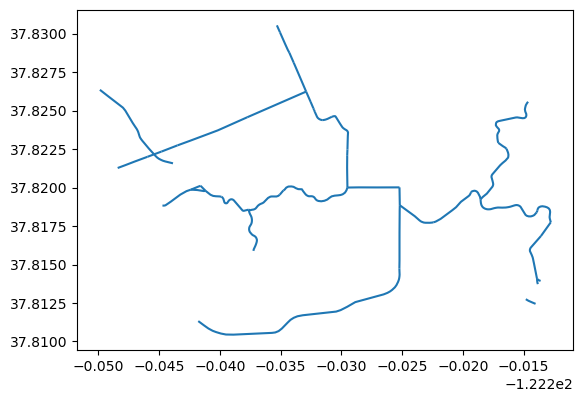

In [5]:
import osmnx as ox
ox.settings.use_cache = False
ox.settings.log_console = True # note: this does not work in Jupyter notebooks
import pandas as pd
import matplotlib.pyplot as plt

place = "Piedmont, California, USA"
tag_list = ['trunk', 'motorway', 'primary', 'secondary','tertiary'] # other tags (e.g., residential, unclassified) have led to timeout errors
tags = {"highway": tag_list} # adjust this to work with the other feature types (e.g., amenities)
date = "2020-01-01T00:00:00Z"

features = pd.DataFrame(columns=['id', 'name', 'geometry', 'highway'])

for tag in tag_list:
    tags = {'highway': [tag]} 
    
    try: 
        single_feature = ox.features_from_place(place, tags=tags)
        features = pd.concat([features, single_feature], ignore_index=True) # append each tag to the features GeoDataFrame
    except Exception as e:
        print(f"Error retrieving data for tag '{tag}': {e}")

# this works fine too
ox.settings.overpass_settings = f'[out:json][timeout:{{timeout}}][date:"{date}"]{{maxsize}}'

# change this variable as necessary
ox.settings.requests_timeout=360

# increasing overpass memory to allow the low-efficiency query of OSM 'attic' data
# WARNING: the ox.settings is a global setting and will affect all subsequent queries
ox.settings.overpass_memory = "3G"
features = ox.features.features_from_place(place, tags)

# reset overpass settings to default
ox.settings.overpass_settings = '[out:json][timeout:{timeout}]{maxsize}'

features.plot('highway')

[OpenHistorical Map](https://wiki.openstreetmap.org/wiki/OpenHistoricalMap)

Text(0.5, 1.0, 'AOI with all sectors highlighted')

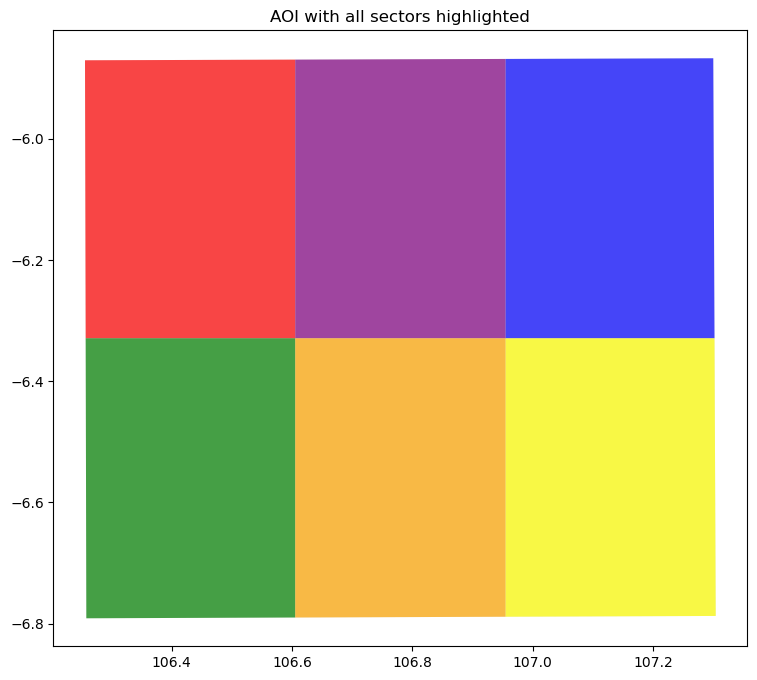

In [6]:
import os
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box

#input a vector and a raster file for each city
AOI_path = Path('../data/processed/')

MUM_file = 'MUM_LIM_reference_AOI_30m.shp' # APS: updated AOI 01.08.2024
MAN_file = 'MAN_LIM_reference_AOI_30m.shp' # APS: updated AOI 01.11.2024
JAK_file = 'JAK_LIM_reference_AOI_30m.shp' # APS: updated AOI 23.08.2024
AOI_gdf = gpd.read_file(AOI_path / JAK_file).to_crs(epsg=4326)



def split_aoi_into_sectors(aoi_gdf):
    # Get the bounding box of the AOI
    minx, miny, maxx, maxy = aoi_gdf.total_bounds
    
    # Calculate division points to split the AOI into 6 sectors (3 horizontal, 2 vertical)
    x1 = minx + (maxx - minx) / 3
    x2 = minx + 2 * (maxx - minx) / 3
    midy = (miny + maxy) / 2
    
    # Create the six sector boxes
    west_top_box = box(minx, midy, x1, maxy)        # Northwest
    center_top_box = box(x1, midy, x2, maxy)        # North-central
    east_top_box = box(x2, midy, maxx, maxy)        # Northeast
    west_bottom_box = box(minx, miny, x1, midy)     # Southwest
    center_bottom_box = box(x1, miny, x2, midy)     # South-central
    east_bottom_box = box(x2, miny, maxx, midy)     # Southeast
    
    # Intersect the boxes with the original AOI to ensure we keep the proper boundary shape
    orig_geom = aoi_gdf.iloc[0].geometry
    west_top_polygon = west_top_box.intersection(orig_geom)
    center_top_polygon = center_top_box.intersection(orig_geom)
    east_top_polygon = east_top_box.intersection(orig_geom)
    west_bottom_polygon = west_bottom_box.intersection(orig_geom)
    center_bottom_polygon = center_bottom_box.intersection(orig_geom)
    east_bottom_polygon = east_bottom_box.intersection(orig_geom)
    
    # Create a dictionary with the six sectors
    sectors = {
        'northwest': gpd.GeoDataFrame(geometry=[west_top_polygon], crs=aoi_gdf.crs),
        'north_central': gpd.GeoDataFrame(geometry=[center_top_polygon], crs=aoi_gdf.crs),
        'northeast': gpd.GeoDataFrame(geometry=[east_top_polygon], crs=aoi_gdf.crs),
        'southwest': gpd.GeoDataFrame(geometry=[west_bottom_polygon], crs=aoi_gdf.crs),
        'south_central': gpd.GeoDataFrame(geometry=[center_bottom_polygon], crs=aoi_gdf.crs),
        'southeast': gpd.GeoDataFrame(geometry=[east_bottom_polygon], crs=aoi_gdf.crs)
    }
    
    return sectors

# Split the AOI and get the top-left sector
AOI_sectors = split_aoi_into_sectors(AOI_gdf)

# Display basic information about the new sector
#print(f"Original AOI area: {AOI_gdf.area.values[0]:.2f} square units")
#print(f"Top-left sector area: {AOI_sectors['northwest'].area.values[0]:.2f} square units")
#print(f"Percentage of original: {(AOI_sectors['northwest'].area.values[0] / AOI_gdf.area.values[0] * 100):.2f}%")

# Plot to visualize
fig, ax = plt.subplots(figsize=(10, 8))
AOI_gdf.plot(ax=ax, color='lightgray', alpha=0.5)
AOI_sectors['northwest'].plot(ax=ax, color='red', alpha=0.7)
AOI_sectors['northeast'].plot(ax=ax, color='blue', alpha=0.7)
AOI_sectors['southwest'].plot(ax=ax, color='green', alpha=0.7)
AOI_sectors['southeast'].plot(ax=ax, color='yellow', alpha=0.7)
AOI_sectors['north_central'].plot(ax=ax, color='purple', alpha=0.7)
AOI_sectors['south_central'].plot(ax=ax, color='orange', alpha=0.7)

ax.set_title('AOI with all sectors highlighted')

### small area test

<Axes: >

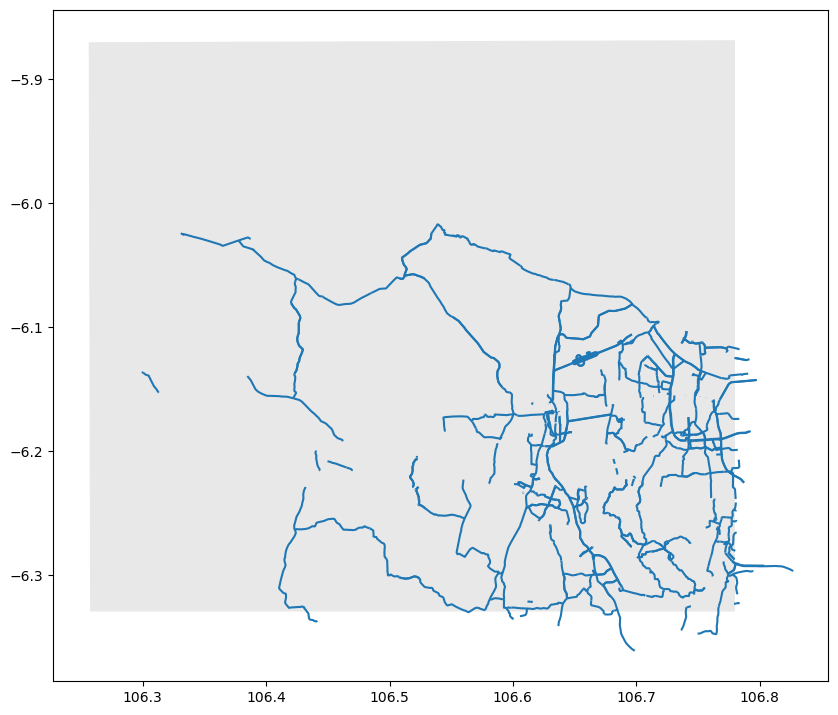

In [6]:
import osmnx as ox
ox.settings.use_cache = False
ox.settings.log_console = True
place = "Piedmont, California, USA"
poly_ca = ox.geocode_to_gdf(place)
poly = AOI_lefttop.geometry.values[0] #.to_crs(epsg=4326)
tags = {"highway": ["primary","secondary"]}
#tags = {'highway': ['primary', 'secondary', 'tertiary', 'residential', 'unclassified', 'trunk', 'motorway']} 

#G = ox.graph.graph_from_place("Piedmont, California, USA", network_type="drive")
#fig, ax = ox.plot.plot_graph(G)

# this works fine
#features = ox.features_from_place(place, tags)
#features = ox.features_from_polygon(poly, tags)

# this works fine too
ox.settings.overpass_settings = '[out:json][timeout:{timeout}][date:"2015-01-01T00:00:00Z"]{maxsize}'
#G = ox.graph.graph_from_place(place, network_type="drive")

# but if you uncomment the code line below, it causes an error
# server remark "runtime error: Query run out of memory using about 2048 MB of RAM"
# features = ox.features.features_from_place(place, tags)

# but if you increase the server memory, it works but takes a pretty long time
ox.settings.overpass_memory = "3G"
#features = ox.features.features_from_place(place, tags)
features = ox.features_from_polygon(poly, tags)
ox.settings.overpass_settings = '[out:json][timeout:{timeout}]{maxsize}'
features.plot(ax=AOI_lefttop.plot(figsize=(10, 10),  alpha=0.5, color='lightgray')) #linewidth=1,'place',


In [ ]:
features.head()

geometry  \
element id                                                            
way     18087408  LINESTRING (106.69572 -6.10623, 106.69516 -6.1...   
        22232337  LINESTRING (106.68837 -6.30929, 106.68785 -6.3...   
        27946607  LINESTRING (106.63441 -6.16424, 106.6343 -6.16...   
        28417798  LINESTRING (106.77215 -6.281, 106.77224 -6.281...   
        28755877  LINESTRING (106.72945 -6.18157, 106.72954 -6.1...   

                                                               name  \
element id                                                            
way     18087408                                 Jalan Raya Bandara   
        22232337                                Jalan Letnan Sutopo   
        27946607  Jl. DR. Sitanala, Koang Jaya, Karawaci, Kota T...   
        28417798                                  Jalan RA. Kartini   
        28755877                           Jalan Lingkar Luar Barat   

                    highway oneway                  source bridge layer width  \
element id                                                                      
way     18087408    primary    yes                     NaN    NaN   NaN   NaN   
        22232337    primary    yes             Yahoo hires    yes     1   NaN   
        27946607    primary    NaN                     NaN    NaN   NaN   NaN   
        28417798  secondary    yes                     NaN    NaN   NaN   NaN   
        28755877    primary    yes  HOT_InAWARESurvey_2017    NaN   NaN     7   

                 lanes smoothness  ... horse access short_name  \
element id                         ...                           
way     18087408   NaN        NaN  ...   NaN    NaN        NaN   
        22232337   NaN        NaN  ...   NaN    NaN        NaN   
        27946607   NaN        NaN  ...   NaN    NaN        NaN   
        28417798   NaN        NaN  ...   NaN    NaN        NaN   
        28755877     2       good  ...   NaN    NaN        NaN   

                 oneway:motorcycle note lanes:both_ways destination tunnel  \
element id                                                                   
way     18087408               NaN  NaN             NaN         NaN    NaN   
        22232337               NaN  NaN             NaN         NaN    NaN   
        27946607               NaN  NaN             NaN         NaN    NaN   
        28417798               NaN  NaN             NaN         NaN    NaN   
        28755877               NaN  NaN             NaN         NaN    NaN   

                 toll name:id  
element id                     
way     18087408  NaN     NaN  
        22232337  NaN     NaN  
        27946607  NaN     NaN  
        28417798  NaN     NaN  
        28755877  NaN     NaN  

[5 rows x 33 columns]

<Axes: >

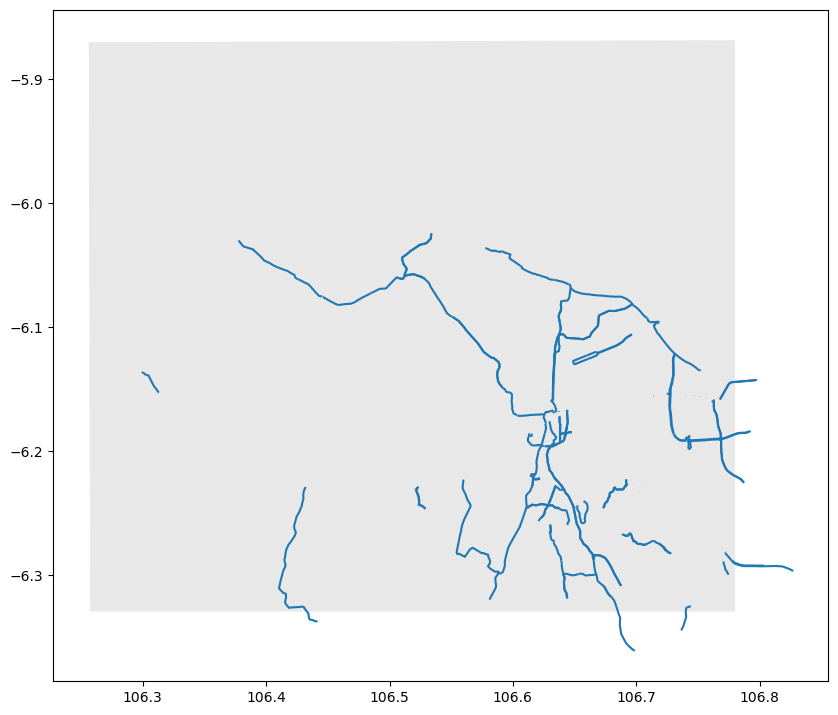

In [15]:
import osmnx as ox
ox.settings.use_cache = False
ox.settings.log_console = True # this does not work in a notebook setting
poly = AOI_gdf.geometry.values[0] # use to_crs(epsg=4326) if necessary
tag_list = ['trunk', 'motorway', 'primary', 'secondary','tertiary', 'residential', 'unclassified']
tags = {'highway': ['primary']} # removing because of OSM read-timeout  'trunk', 'motorway', , 'secondary','tertiary', 'residential', 'unclassified',
col_list = ['id','name','source','geometry', 'highway','surface','lanes','incline'] 
major_crit = {'highway': ['primary', 'secondary','trunk', 'motorway']}

date = "2015-01-01T00:00:00Z"
ox.settings.overpass_settings = f'[out:json][timeout:{{timeout}}][date:"{date}"]{{maxsize}}'
ox.settings.requests_timeout=400
# increasing overpass memory to allow the low-efficiency query of OSM 'attic' data
# WARNING: the ox.settings is a global setting and will affect all subsequent queries
ox.settings.overpass_memory = "3G"
#features = ox.features_from_polygon(poly, tags)
primary = ox.features_from_bbox(bbox=(AOI_lefttop.bounds.values[0][0], # left
                                            AOI_lefttop.bounds.values[0][1], # old south, now bottom
                                            AOI_lefttop.bounds.values[0][2], # old east, now right
                                            AOI_lefttop.bounds.values[0][3]), # old north, now top
                                            tags=tags)

# reset overpass settings to default
ox.settings.overpass_settings = '[out:json][timeout:{timeout}]{maxsize}'
primary.plot(ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray')) #linewidth=1,'place',


### full area

Error retrieving data for tag 'residential': No matching features. Check query location, tags, and log.


<Axes: >

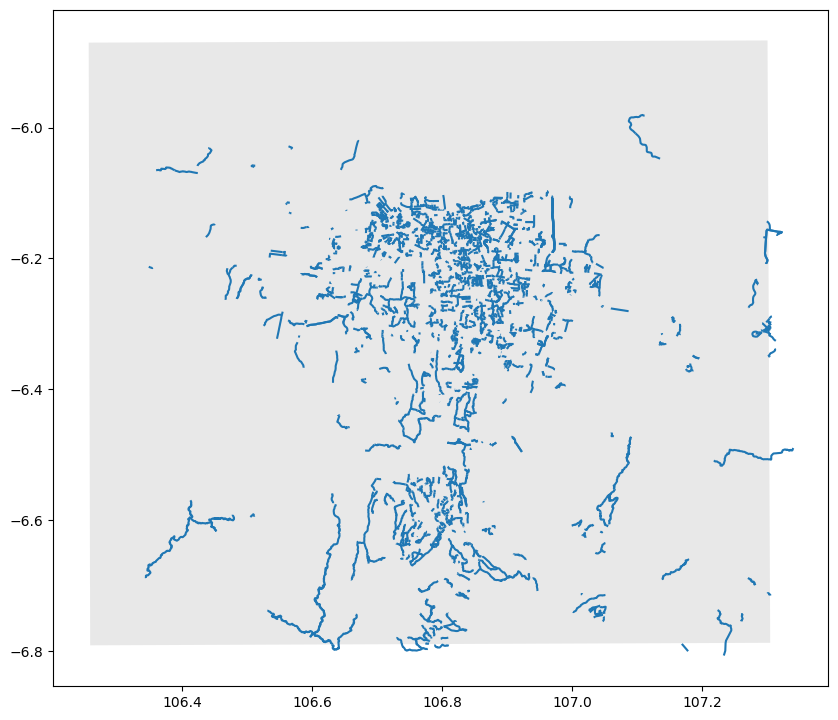

In [7]:
import osmnx as ox
ox.settings.use_cache = False
ox.settings.log_console = True # this does not work in a notebook setting
import pandas as pd
col_list = ['id','name','source','geometry', 'highway','surface','lanes','incline'] 
poly = AOI_gdf.geometry.values[0] # use to_crs(epsg=4326) if necessary
bbox = (AOI_gdf.bounds.values[0][0], # left
            AOI_gdf.bounds.values[0][1], # old south, now bottom
            AOI_gdf.bounds.values[0][2], # old east, now right
            AOI_gdf.bounds.values[0][3]) # old north, now top

date = "2015-01-01T00:00:00Z"
ox.settings.overpass_settings = f'[out:json][timeout:{{timeout}}][date:"{date}"]{{maxsize}}'
ox.settings.requests_timeout=1540 # tried 180 (default), 360
# increasing overpass memory to allow the low-efficiency query of OSM 'attic' data
# WARNING: the ox.settings is a global setting and will affect all subsequent queries
ox.settings.overpass_memory = "3G"

# initialize an empty geodataframe
roads_2015 = gpd.GeoDataFrame(columns=col_list)

#tag_list = ['trunk', 'motorway', 'primary', 'secondary','tertiary'] # this took 219 min and resulted in an error for the tag 'residential'
#tag_list = ['primary', 'secondary'] # this took 23 min
tag_list = ['tertiary','residential'] #, 'unclassified']

for tag in tag_list:
    tags = {'highway': [tag]} # removing because of OSM read-timeout  'trunk', 'motorway', , 'secondary','tertiary', 'residential', 'unclassified',
    #features = ox.features_from_polygon(poly, tags)
    try: 
        single_feature = ox.features_from_bbox(bbox=bbox, # old north, now top
                                                tags=tags)
        # append each tag to the features GeoDataFrame
        roads_2015 = pd.concat([roads_2015, single_feature], ignore_index=True)
    except Exception as e:
        print(f"Error retrieving data for tag '{tag}': {e}")

# reset overpass settings to default
ox.settings.overpass_settings = '[out:json][timeout:{timeout}]{maxsize}'


roads_2015.plot('highway',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray')) #linewidth=1,'place',

highway
tertiary     3108
secondary    2055
primary      1557
trunk         513
motorway      336
Name: count, dtype: int64


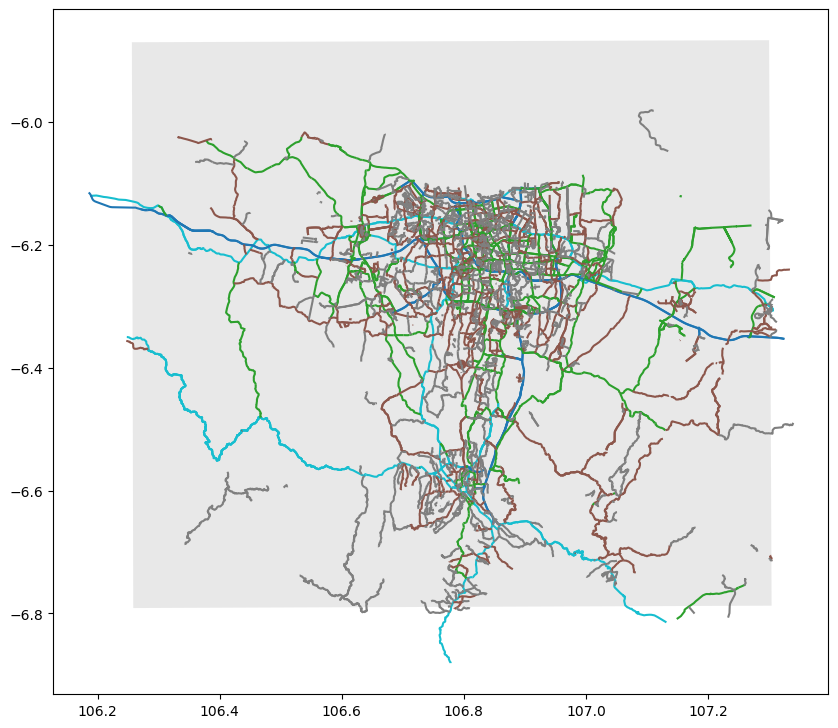

In [40]:
lines.plot('highway',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray')) #linewidth=1,'place',
print(lines.highway.value_counts())

### export a shapefile

In [ ]:
import rasterio
from rasterio.warp import reproject, calculate_default_transform, Resampling
case_city = 'JAK' #MUM MAN JAK
interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\interim\\')
ref_raster_path = Path('../data/processed/JAK_LIM_reference_AOI_150m.tif')
%run ./ti_city_00_raster_functions.ipynb
major_crit = {'highway': ['primary', 'secondary','trunk', 'motorway']}
geom_type = 'LineString'

temp_places = lines.loc[:, col_list]
temp_places[temp_places['geometry'].type == 'MultiLineString'].explode()
temp_places = temp_places[temp_places['geometry'].type == geom_type]
places = gpd.clip(temp_places, mask=AOI_gdf, keep_geom_type=True)

places['major'] = 0
    # identify major features based on the criteria dictionary
for key, value in major_crit.items():
    places.loc[places[key].isin(value), 'major'] = 1

roads_2015_file_name = case_city + '_TRA_roads_OSM_2015'

export_files(gdf=places, 
             major_raster=None, 
             full_raster=None, 
             distance_raster=None, 
             distance_normal=None, 
             out_path=interim_path, 
             file_name = roads_2015_file_name)

In [36]:
print(places['geometry'].type.unique())

['LineString' 'MultiLineString']


### iterate through the sectors to get the 'residential' and 'unclassified' tags

In [5]:
AOI_sectors.keys()

dict_keys(['northwest', 'north_central', 'northeast', 'southwest', 'south_central', 'southeast'])

Processing southwest sector
  Bounding box: (106.25722026781342, -6.791314577241045, 106.6054574533193, -6.329088921777238)
  Fetching tag: residential
  Error fetching residential in southwest: No matching features. Check query location, tags, and log.
Processing south_central sector
  Bounding box: (106.6054574533193, -6.790038883798065, 106.9548046281266, -6.329088921777238)
  Fetching tag: residential
  Error fetching residential in south_central: No matching features. Check query location, tags, and log.
Processing southeast sector
  Bounding box: (106.9548046281266, -6.788755002241223, 107.30415180293387, -6.329088921777238)
  Fetching tag: residential
  Error fetching residential in southeast: No matching features. Check query location, tags, and log.


C:\Users\ra42zek\AppData\Local\Temp\ipykernel_25632\2659906657.py:44: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  lines_sectors.plot('highway',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray')) #linewidth=1,'place',


<Axes: >

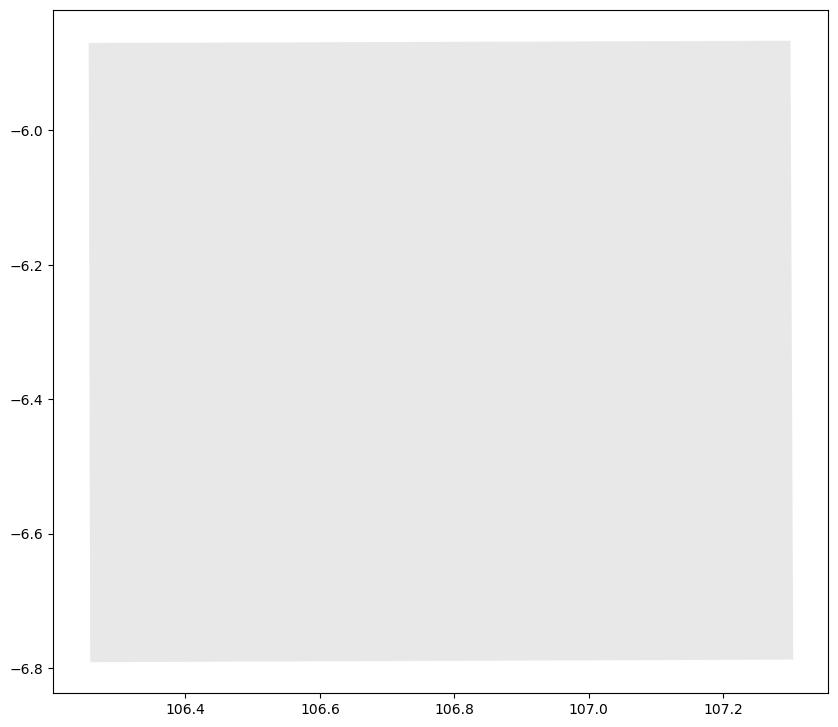

In [9]:
import osmnx as ox
ox.settings.use_cache = False
ox.settings.log_console = True # this does not work in a notebook setting
import pandas as pd
poly = AOI_gdf.geometry.values[0] # use to_crs(epsg=4326) if necessary
col_list = ['id','name','source','geometry', 'highway','surface','lanes','incline'] 
date = "2015-01-01T00:00:00Z"
ox.settings.overpass_settings = f'[out:json][timeout:{{timeout}}][date:"{date}"]{{maxsize}}'
ox.settings.requests_timeout=400
# increasing overpass memory to allow the low-efficiency query of OSM 'attic' data
# WARNING: the ox.settings is a global setting and will affect all subsequent queries
ox.settings.overpass_memory = "3G"

# initialize an empty geodataframe
lines_sectors = gpd.GeoDataFrame(columns=col_list)

#tag_list = ['trunk', 'motorway', 'primary', 'secondary','tertiary'] # this took 219 min and resulted in an error for the tag 'residential'
#tag_list = ['primary', 'secondary'] # this took 23 min
#tag_list = ['residential', 'unclassified'] 
#tag_list = ['trunk'] # APS 22.08.25 this works with one sector
tag_list = ['residential']
for sector in ['southwest', 'south_central', 'southeast']: #['northwest', 'north_central', 'northeast']: #, 'southwest'
    print(f"Processing {sector} sector") 
    bbox = (AOI_sectors[sector].bounds.values[0][0], # left
            AOI_sectors[sector].bounds.values[0][1], # bottom
            AOI_sectors[sector].bounds.values[0][2], # right
            AOI_sectors[sector].bounds.values[0][3]) # top
    print(f"  Bounding box: {bbox}")
    for tag in tag_list:
        print(f"  Fetching tag: {tag}")
        tags = {'highway': [tag]}
        try:
            single_feature = ox.features_from_bbox(bbox=bbox,
                                                tags=tags)
            print(f"  Found {len(single_feature)} features")
            # append each tag to the features GeoDataFrame
            lines_sectors = pd.concat([lines_sectors, single_feature], ignore_index=True)
        except Exception as e:
            print(f"  Error fetching {tag} in {sector}: {e}")
# reset overpass settings to default
ox.settings.overpass_settings = '[out:json][timeout:{timeout}]{maxsize}'


lines_sectors.plot('highway',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray')) #linewidth=1,'place',

In [ ]:
import datetime
import shapely

date=datetime.datetime.fromisoformat("2023-12-31T10:15:23.355030")
poli = AOI_gdf_4326
ox.settings.requests_timeout=200
ox.settings.use_cache=False
ox.settings.log_console = True
ox.settings.overpass_settings=f"[out:json][timeout:{ox.settings.requests_timeout}][date:\"{date}\"]"
geom=poli.iloc[0]['geometry'] #shapely.wkt.loads(poli)
tags={"highway":"primary"}
ox.settings.overpass_memory = "3G"
features = ox.features_from_polygon(
        geom,
        tags,
    )
print(len(features))

In [ ]:
## raster list with the distance function

continuous_list = [case_city + '_LOC_airports_OSM_2025_distance_normal_150m.tif', # APS: until 06/03/2025 '_LOC_airports_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_attractive_areas_OSM_2025_distance_normal_150m.tif', # APS: until 06/03/2025 '_LOC_attractive_areas_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_CBDs_OSM_2025_distance_normal_150m.tif', # APS: until 06/03/2025 '_LOC_CBDs_OSM_2024_distance_normal_150m.tif', 
                   case_city + '_LOC_health_OSM_2025_distance_normal_150m.tif', # APS: until 06/03/2025 '_LOC_health_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_malls_OSM_2025_distance_normal_150m.tif', # APS: until 06/03/2025 '_LOC_malls_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_markets_OSM_2025_distance_normal_150m.tif', # APS: until 06/03/2025 '_LOC_markets_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_schools_OSM_2025_distance_normal_150m.tif', # APS: until 06/03/2025 '_LOC_schools_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_suburban_centres_OSM_2025_distance_normal_150m.tif', # APS: until 06/03/2025 '_LOC_suburban_centres_OSM_2024_distance_normal_150m.tif',
                   case_city + '_POP_density_normal_2000_WDPop_150m.tif',
                   case_city + '_POP_density_normal_2020_WDPop_150m.tif',
                   case_city + '_TRA_roads_OSM_2025_distance_normal_150m.tif',
                   case_city + '_URB_distance_urbanisation_2000_EOC_WUF_150m.tif',
                   case_city + '_URB_distance_urbanisation_2015_EOC_WUF_150m.tif',
                   case_city + '_HYD_water_distance_normal_150m.tif']
